In [1]:
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import matplotlib.axes as axe
import pandas as pd
import datetime as dt
import gurobipy as gp
from gurobipy import GRB
import cvxpy as cp

import random
from itertools import chain, combinations, tee
import time


# General CBCP Equilibrium Solver

## (Special Case) Quartic Polynomial Latency Functions

In [2]:
x_temp = np.array([0, 1, 2, 3, 4])
x_temp[-2:]

array([3, 4])

In [3]:
arr = np.array([[1, 2, 3, 4, 5], [6, 7, 8, 9, 10], [11, 12, 13, 14, 15]])
# num_cols = arr.shape[1]
num_cols = 3
# arr[:, -num_cols:] - arr[:, -num_cols-1:-1]

np.linalg.norm(arr, axis=0)


array([12.56980509, 14.03566885, 15.55634919, 17.11724277, 18.70828693])

In [4]:
grad = np.array([0, 1, 2, 3, 4])

grad[2:]

array([2, 3, 4])

In [5]:

def solve_CBCP_direct_11(tau, B, v_I, v_E, a = np.array([0.0, 0.0, 0.0, 0.0, 1.0])):

    # y_el: \hat y_1, \tilde y_1, y_2
    y_el = cp.Variable(3)
    # y_in: y_1, y_2
    y_in = cp.Variable(2)
    
    func = 1/5 * a[4] * cp.power(y_el[0] + y_el[1] + y_in[0], 5)
    func += 1/4 * a[3] * cp.power(y_el[0] + y_el[1] + y_in[0], 4)
    func += 1/3 * a[2] * cp.power(y_el[0] + y_el[1] + y_in[0], 3)
    func += 1/2 * a[1] * cp.power(y_el[0] + y_el[1] + y_in[0], 2)
    func += a[0] * (y_el[0] + y_el[1] + y_in[0])
    func += y_in[0] * tau / v_I + y_el[0] * tau / v_E
    func += 1/5 * a[4] * cp.power(y_el[2] + y_in[1], 5)
    func += 1/4 * a[3] * cp.power(y_el[2] + y_in[1], 4)
    func += 1/3 * a[2] * cp.power(y_el[2] + y_in[1], 3)
    func += 1/2 * a[1] * cp.power(y_el[2] + y_in[1], 2)
    func += a[0] * (y_el[2] + y_in[1])

    objective = cp.Minimize(func)
    
    constraints = []
    constraints += [y_el >= 0, y_in >= 0]
    constraints += [cp.sum(y_el) == 1, cp.sum(y_in) == 1]
    constraints += [y_el[1] * tau <= B]
    
    prob = cp.Problem(objective, constraints)
    
    # The optimal objective value is returned by `prob.solve()`.
    result = prob.solve()
#     # The optimal value for x is stored in `x.value`.
#     print("In solve_CBCP_direct, y_el.value:", y_el.value)
#     print("In solve_CBCP_direct, y_in.value:", y_in.value)

    return y_el.value, y_in.value


In [28]:
def welfare_obj(lambda_E, lambda_R, lambda_I, tau, v_I, v_E, y_el, y_in, a):
    
    # y = (\hat y_1 E, \tilde y_1 E, y_2 E, y_1 I, y_2 I)
    # y_el = (\hat y_1 E, \tilde y_1 E, y_2 E)
    # y_in = (y_1 I, y_2 I)
    
    ell_1 = a[4] * (y_el[0] + y_el[1] + y_in[0])**4 \
            + a[3] * (y_el[0] + y_el[1] + y_in[0])**3 \
            + a[2] * (y_el[0] + y_el[1] + y_in[0])**2 \
            + a[1] * (y_el[0] + y_el[1] + y_in[0]) \
            + a[0]
        
    ell_2 = a[4] * (y_el[2] + y_in[1])**4 \
            + a[3] * (y_el[2] + y_in[1])**3 \
            + a[2] * (y_el[2] + y_in[1])**2 \
            + a[1] * (y_el[2] + y_in[1]) \
            + a[0]
    
    obj_E = tau * y_el[0] + v_E * (ell_1 * (y_el[0] + y_el[1]) + ell_2 * y_el[2])
    obj_R = tau * (y_el[0] + y_in[0])
    obj_I = tau * y_in[0] + v_I * (ell_1 * y_in[0] + ell_2 * y_in[1] )
    
#     print("ell_1:", ell_1)
#     print("ell_2:", ell_2)
#     print("obj_E:", obj_E)
#     print("obj_R:", obj_R)

#     print("tau:", tau)
#     print("y_in[0]:", y_in[0])
#     print("v_I:", v_I)
#     print("ell_1:", ell_1)
#     print("y_el[0] + y_el[1] + y_el[2]:", y_el[0] + y_el[1] + y_el[2])
#     print("ell_2:", ell_2)
#     print("y_in[0] + y_in[1]:", y_in[0] + y_in[1])

#     print("obj_I:", obj_I)

    return lambda_E * obj_E - lambda_R * obj_R + lambda_I * obj_I

    

In [19]:
def proj_tau_B_11(tau, B):
    if B <= tau and 0 <= tau <= 1 and 0 <= B <= 1:
        return tau, B
    # Case 1:
    elif tau > 1 and 0 < B <= 1:
        return 1.0, B
    # Case 2:
    elif tau > 1 and B <= 0:
        return 1.0, 0.0
    # Case 3:
    elif 0 < tau <= 1 and B < 0:
        return tau, 0.0
    # Case 4:
    elif tau <= 0 and B + tau < 0:
        return 0.0, 0.0
    # Case 5:
    elif 0 <= B + tau < 2 and B > tau:
        return (B + tau)/2, (B + tau)/2
    # Case 6:
    elif B + tau >= 2 and B > 1:
        return 1.0, 1.0
    else:
        assert 1 == 0, "This case should not happen!"

## Chinmay's Algorithm:

In [38]:
time_1 = time.time()

tau = 0.4
B = 0.3
v_I = 1.0
v_E = 0.6
a = np.array([0.0, 0.0, 0.0, 0.0, 1.0])
num_iters_max = 5000
error_bound = 1E-3
diffs_num_cols = 5
y_init = np.array([0.0, 0.05, 0.95, 0.95, 0.05])
lambda_E, lambda_R, lambda_I = 1.0, 1.0, 1.0
# lambda_E, lambda_R, lambda_I = 1.0, 0.2, 1.0
# lambda_E, lambda_R, lambda_I = 1.0, 1.5, 1.0

tau_max, B_max = 1.0, 1.0
d = 2
num_iters = 1000
tau = np.zeros(num_iters)
tau_perturbed = np.zeros(num_iters)
B = np.zeros(num_iters)
B_perturbed = np.zeros(num_iters)
tau_B_iters = np.zeros((2, num_iters))
delta = np.zeros(num_iters)
eta = np.zeros(num_iters)
eta_bar = 0.5
delta_bar = 0.5

welfare_list = []

tau[0] = 0.8
B[0] = 0.2

for i in range(num_iters-1):
    
    print()
    print("Iter:", i)
    
    eta[i] = eta_bar * (i+1)**(-1/2) * d**(-1)
    delta[i] = delta_bar * (i+1)**(-1/4) * d**(-1/2)
    w_i_unnormalized = np.random.randn(2)
    w_i = w_i_unnormalized / np.linalg.norm(w_i_unnormalized)
    print("w_i:", w_i)
    tau_perturbed[i] = tau[i] + delta[i] * w_i[0]
    B_perturbed[i] = B[i] + delta[i] * w_i[1]
    
    if tau_perturbed[i] < B_perturbed[i] or tau_perturbed[i] < 0 or B_perturbed[i] < 0:
        tau_perturbed[i], B_perturbed[i] = proj_tau_B_11(tau_perturbed[i], B_perturbed[i])
    
    # TODO
#     if B_perturbed[i] <= tau_perturbed[i] and B_perturbed[i] >= 0 and tau_perturbed[i] >= 0:        
    
#     print()
#     print("New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):")
#     print()
    print("tau[i]:", tau[i])
    print("B[i]:", B[i])
    print("tau_perturbed[i]:", tau_perturbed[i])
    print("B_perturbed[i]:", B_perturbed[i])


    y_el, y_in = solve_CBCP_direct_11(tau = tau[i], B = B[i], v_I = v_I, v_E = v_E, a = a)
    

#     print()
#     print("New solve_CBCP_iter_11 call to solve_CBCP (perturbed):")
#     print()
    y_el_perturbed, y_in_perturbed = solve_CBCP_direct_11(tau = tau_perturbed[i], B = B_perturbed[i], v_I = v_I, v_E = v_E, a = a)
    
#     print("y_el:", y_el)
#     print("y_in:", y_in)
#     print("y_el_perturbed:", y_el_perturbed)
#     print("y_in_perturbed:", y_in_perturbed)
    
    welfare = welfare_obj(lambda_E, lambda_R, lambda_I, tau = tau[i], v_I = v_I, v_E = v_E, \
                          y_el = y_el, y_in = y_in, a = a)
    welfare_perturbed = welfare_obj(lambda_E, lambda_R, lambda_I, tau = tau_perturbed[i], v_I = v_I, v_E = v_E, \
                                    y_el = y_el_perturbed, y_in = y_in_perturbed, a = a)
    
    welfare_list.append(welfare)
    
    print("welfare:", welfare)
    print("welfare_perturbed:", welfare_perturbed)
#     print("tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):\n", tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare))
    
    tau[i+1] = tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare)
    B[i+1] = B[i] - eta[i] * (d/delta[i]) * w_i[1] * (welfare_perturbed - welfare)

    if not (B[i+1] <= tau[i+1] and 0 <= tau[i+1] <= 1 and 0 <= B[i+1] <= 1):
        tau[i+1], B[i+1] = proj_tau_B_11(tau[i+1], B[i+1])
        
    if i >= diffs_num_cols + 2:
        tau_diffs = tau[i-diffs_num_cols : i-1] - tau[i-diffs_num_cols+1 : i]
        B_diffs = B[i-diffs_num_cols : i-1] - B[i-diffs_num_cols+1 : i]
        
#         print("tau[0:10]:", tau[0:10])
#         print("B[0:10]:", B[0:10])
        print("tau_diffs:", tau_diffs)
        print("B_diffs:", B_diffs)
        
        if max(np.max(np.absolute(tau_diffs)), np.max(np.absolute(B_diffs))) < error_bound:
            break

time_2 = time.time()

min_welfare = min(welfare_list)
argmin_welfare_list = welfare_list.index(min(welfare_list))
argmin_tau = tau[argmin_welfare_list]
argmin_B = B[argmin_welfare_list]

print()
print("Time:", time_2 - time_1)




Iter: 0
w_i: [ 0.83547716 -0.54952518]
tau[i]: 0.8
B[i]: 0.2
tau_perturbed[i]: 1.095385781706344
B_perturbed[i]: 0.005713510593937016
welfare: 1.6935225534581637
welfare_perturbed: 1.7046869136697453

Iter: 1
w_i: [ 0.97905003 -0.20361983]
tau[i]: 0.786808826926603
B[i]: 0.2086763374078917
tau_perturbed[i]: 1.077882142574233
B_perturbed[i]: 0.14813979830782814
welfare: 1.6940320378404543
welfare_perturbed: 1.7552266355192652

Iter: 2
w_i: [-0.99873254 -0.05033195]
tau[i]: 0.7155603691422261
B[i]: 0.22349437402827568
tau_perturbed[i]: 0.4472583786479922
B_perturbed[i]: 0.20997307432982615
welfare: 1.685496925289159
welfare_perturbed: 1.6493087419886203

Iter: 3
w_i: [0.99952512 0.03081447]
tau[i]: 0.6767229226946072
B[i]: 0.22153712894047964
tau_perturbed[i]: 0.9266042030279119
B_perturbed[i]: 0.22924074750505122
welfare: 1.6779272231703397
welfare_perturbed: 1.7380845836622538

Iter: 4
w_i: [ 0.13401186 -0.99097973]
tau[i]: 0.6165941296498406
B[i]: 0.2196834115041551
tau_perturbed[i]:

welfare: 1.5660058353322803
welfare_perturbed: 1.5783989207581324
tau_diffs: [-0.01813332  0.00892762  0.00018059  0.00690638]
B_diffs: [ 0.00187215 -0.00384525 -0.00072884 -0.00317303]

Iter: 29
w_i: [-0.9906382  -0.13651357]
tau[i]: 0.4549136935594771
B[i]: 0.003006489053731827
tau_perturbed[i]: 0.30525919921802624
B_perturbed[i]: 0.0
welfare: 1.5668645675763049
welfare_perturbed: 1.564518552670948
tau_diffs: [0.00892762 0.00018059 0.00690638 0.01377192]
B_diffs: [-0.00384525 -0.00072884 -0.00317303  0.00774712]

Iter: 30
w_i: [-0.32127908 -0.94698456]
tau[i]: 0.4535093268619623
B[i]: 0.002812962178285704
tau_perturbed[i]: 0.40537033005163486
B_perturbed[i]: 0.0
welfare: 1.5667204698962964
welfare_perturbed: 1.5639477200085306
tau_diffs: [0.00018059 0.00690638 0.01377192 0.00692838]
B_diffs: [-0.00072884 -0.00317303  0.00774712 -0.00300649]

Iter: 31
w_i: [0.25371831 0.96727815]
tau[i]: 0.45297541726995033
B[i]: 0.0012392396303401046
tau_perturbed[i]: 0.49069086896123615
B_perturbed[

welfare: 1.5656249563941105
welfare_perturbed: 1.5793924619204898
tau_diffs: [-0.00427142 -0.00870058  0.00094162  0.01648984]
B_diffs: [0. 0. 0. 0.]

Iter: 55
w_i: [-0.93571822 -0.35274837]
tau[i]: 0.44701221612414505
B[i]: 0.0
tau_perturbed[i]: 0.3260769161543145
B_perturbed[i]: 0.0
welfare: 1.565299949660216
welfare_perturbed: 1.5639535820687356
tau_diffs: [-0.00870058  0.00094162  0.01648984  0.00088161]
B_diffs: [0. 0. 0. 0.]

Iter: 56
w_i: [-0.95849252  0.28511766]
tau[i]: 0.4463609226499637
B[i]: 0.0
tau_perturbed[i]: 0.3230291360614155
B_perturbed[i]: 0.03668684887244807
welfare: 1.5652716453826756
welfare_perturbed: 1.5786969176250552
tau_diffs: [0.00094162 0.01648984 0.00088161 0.0071364 ]
B_diffs: [0. 0. 0. 0.]

Iter: 57
w_i: [0.98894918 0.14825494]
tau[i]: 0.45298397389432493
B[i]: 0.0
tau_perturbed[i]: 0.5796826220923439
B_perturbed[i]: 0.018993595032535004
welfare: 1.565570056042364
welfare_perturbed: 1.5833759736495137
tau_diffs: [0.01648984 0.00088161 0.0071364  0.00065

welfare: 1.564655329548187
welfare_perturbed: 1.5905389458280603
tau_diffs: [ 3.98313582e-03 -5.37238117e-06  5.00863102e-04 -1.58966872e-04]
B_diffs: [ 1.47270970e-04  4.32248257e-05 -7.87474962e-04 -6.44495975e-05]

Iter: 80
w_i: [ 0.88735617 -0.46108463]
tau[i]: 0.4129911724328669
B[i]: 0.0
tau_perturbed[i]: 0.5175670994545192
B_perturbed[i]: 0.0
welfare: 1.5641256178748968
welfare_perturbed: 1.5697067429081875
tau_diffs: [-5.37238117e-06  5.00863102e-04 -1.58966872e-04  1.74386445e-05]
B_diffs: [ 4.32248257e-05 -7.87474962e-04 -6.44495975e-05  1.09984047e-05]

Time: 12.132897138595581


In [39]:
print("min(welfare_list):", min(welfare_list))
print("argmin_tau:", argmin_tau)
print("argmin_B:", argmin_B)

min(welfare_list): 1.5640067151430288
argmin_tau: 0.40804999582628987
argmin_B: 0.0


## Grid Search:

In [31]:
# tau = 0.5
# B = 0.5
# v_I = 1.0
# v_E = 0.6
# a = np.array([0.0, 0.0, 0.0, 0.0, 1.0])

# lambda_E, lambda_R, lambda_I = 1.0, 1.5, 1.0

# y_el_point_5, y_in_point_5 = solve_CBCP_direct_11(tau = tau, B = B, v_I = v_I, v_E = v_E, a = a)

# welfare_obj_arr[tau_index][B_index] = welfare_obj(lambda_E, lambda_R, lambda_I, tau, v_I, v_E, \
#                                                   y_el_point_5, y_in_point_5, \
#                                                   a = a)


In [35]:
time_1 = time.time()

tau = 0.4
B = 0.3
v_I = 1.0
v_E = 0.6
a = np.array([0.0, 0.0, 0.0, 0.0, 1.0])
num_iters_max = 5000
error_bound = 1E-3
diffs_num_cols = 5
y_init = np.array([0.0, 0.0, 1.0, 1.0, 0.0])
lambda_E, lambda_R, lambda_I = 1.0, 1.0, 1.0
# lambda_E, lambda_R, lambda_I = 1.0, 0.2, 1.0
# lambda_E, lambda_R, lambda_I = 1.0, 1.5, 1.0


grid_size = 0.02
tau_arr = (np.arange(int(1/grid_size)) + 1) * grid_size
B_arr = (np.arange(int(1/grid_size)) + 1) * grid_size

welfare_obj_arr = np.ones((tau_arr.shape[0], B_arr.shape[0])) * 100
y_el_arr = np.zeros((tau_arr.shape[0], B_arr.shape[0], 3))
y_in_arr = np.zeros((tau_arr.shape[0], B_arr.shape[0], 2))
welfare_obj_list = []

for tau_index, tau in enumerate(tau_arr):
    for B_index, B in enumerate(B_arr):
        if B < tau:
            print("tau:", tau)
            print("B:", B)
            y_el_arr[tau_index, B_index, :], y_in_arr[tau_index, B_index, :] \
                = solve_CBCP_direct_11(tau = tau, B = B, v_I = v_I, v_E = v_E, a = a)
            
#             def solve_CBCP_direct_11(tau, B, v_I, v_E, a = np.array([0.5, 1.0])):
            
            welfare_obj_arr[tau_index][B_index] = welfare_obj(lambda_E, lambda_R, lambda_I, tau, v_I, v_E, \
                                                              y_el = y_el_arr[tau_index, B_index, :], y_in = y_in_arr[tau_index, B_index, :], \
                                                              a = a)
            welfare_obj_list.append(welfare_obj_arr[tau_index][B_index])
            
            print()

time_2 = time.time()

print("Time:", time_2 - time_1)



tau: 0.04
B: 0.02

tau: 0.06
B: 0.02

tau: 0.06
B: 0.04

tau: 0.08
B: 0.02

tau: 0.08
B: 0.04

tau: 0.08
B: 0.06

tau: 0.1
B: 0.02

tau: 0.1
B: 0.04

tau: 0.1
B: 0.06

tau: 0.1
B: 0.08

tau: 0.12
B: 0.02

tau: 0.12
B: 0.04

tau: 0.12
B: 0.06

tau: 0.12
B: 0.08

tau: 0.12
B: 0.1

tau: 0.14
B: 0.02

tau: 0.14
B: 0.04

tau: 0.14
B: 0.06

tau: 0.14
B: 0.08

tau: 0.14
B: 0.1

tau: 0.14
B: 0.12

tau: 0.16
B: 0.02

tau: 0.16
B: 0.04

tau: 0.16
B: 0.06

tau: 0.16
B: 0.08

tau: 0.16
B: 0.1

tau: 0.16
B: 0.12

tau: 0.16
B: 0.14

tau: 0.18
B: 0.02

tau: 0.18
B: 0.04

tau: 0.18
B: 0.06

tau: 0.18
B: 0.08

tau: 0.18
B: 0.1

tau: 0.18
B: 0.12

tau: 0.18
B: 0.14

tau: 0.18
B: 0.16

tau: 0.2
B: 0.02

tau: 0.2
B: 0.04

tau: 0.2
B: 0.06

tau: 0.2
B: 0.08

tau: 0.2
B: 0.1

tau: 0.2
B: 0.12

tau: 0.2
B: 0.14

tau: 0.2
B: 0.16

tau: 0.2
B: 0.18

tau: 0.22
B: 0.02

tau: 0.22
B: 0.04

tau: 0.22
B: 0.06

tau: 0.22
B: 0.08

tau: 0.22
B: 0.1

tau: 0.22
B: 0.12

tau: 0.22
B: 0.14

tau: 0.22
B: 0.16

tau: 0.22
B:


tau: 0.62
B: 0.14

tau: 0.62
B: 0.16

tau: 0.62
B: 0.18

tau: 0.62
B: 0.2

tau: 0.62
B: 0.22

tau: 0.62
B: 0.24

tau: 0.62
B: 0.26

tau: 0.62
B: 0.28

tau: 0.62
B: 0.3

tau: 0.62
B: 0.32

tau: 0.62
B: 0.34

tau: 0.62
B: 0.36

tau: 0.62
B: 0.38

tau: 0.62
B: 0.4

tau: 0.62
B: 0.42

tau: 0.62
B: 0.44

tau: 0.62
B: 0.46

tau: 0.62
B: 0.48

tau: 0.62
B: 0.5

tau: 0.62
B: 0.52

tau: 0.62
B: 0.54

tau: 0.62
B: 0.56

tau: 0.62
B: 0.58

tau: 0.62
B: 0.6

tau: 0.64
B: 0.02

tau: 0.64
B: 0.04

tau: 0.64
B: 0.06

tau: 0.64
B: 0.08

tau: 0.64
B: 0.1

tau: 0.64
B: 0.12

tau: 0.64
B: 0.14

tau: 0.64
B: 0.16

tau: 0.64
B: 0.18

tau: 0.64
B: 0.2

tau: 0.64
B: 0.22

tau: 0.64
B: 0.24

tau: 0.64
B: 0.26

tau: 0.64
B: 0.28

tau: 0.64
B: 0.3

tau: 0.64
B: 0.32

tau: 0.64
B: 0.34

tau: 0.64
B: 0.36

tau: 0.64
B: 0.38

tau: 0.64
B: 0.4

tau: 0.64
B: 0.42

tau: 0.64
B: 0.44

tau: 0.64
B: 0.46

tau: 0.64
B: 0.48

tau: 0.64
B: 0.5

tau: 0.64
B: 0.52

tau: 0.64
B: 0.54

tau: 0.64
B: 0.56

tau: 0.64
B: 0.58

ta


tau: 0.84
B: 0.04

tau: 0.84
B: 0.06

tau: 0.84
B: 0.08

tau: 0.84
B: 0.1

tau: 0.84
B: 0.12

tau: 0.84
B: 0.14

tau: 0.84
B: 0.16

tau: 0.84
B: 0.18

tau: 0.84
B: 0.2

tau: 0.84
B: 0.22

tau: 0.84
B: 0.24

tau: 0.84
B: 0.26

tau: 0.84
B: 0.28

tau: 0.84
B: 0.3

tau: 0.84
B: 0.32

tau: 0.84
B: 0.34

tau: 0.84
B: 0.36

tau: 0.84
B: 0.38

tau: 0.84
B: 0.4

tau: 0.84
B: 0.42

tau: 0.84
B: 0.44

tau: 0.84
B: 0.46

tau: 0.84
B: 0.48

tau: 0.84
B: 0.5

tau: 0.84
B: 0.52

tau: 0.84
B: 0.54

tau: 0.84
B: 0.56

tau: 0.84
B: 0.58

tau: 0.84
B: 0.6

tau: 0.84
B: 0.62

tau: 0.84
B: 0.64

tau: 0.84
B: 0.66

tau: 0.84
B: 0.68

tau: 0.84
B: 0.7000000000000001

tau: 0.84
B: 0.72

tau: 0.84
B: 0.74

tau: 0.84
B: 0.76

tau: 0.84
B: 0.78

tau: 0.84
B: 0.8

tau: 0.84
B: 0.8200000000000001

tau: 0.86
B: 0.02

tau: 0.86
B: 0.04

tau: 0.86
B: 0.06

tau: 0.86
B: 0.08

tau: 0.86
B: 0.1

tau: 0.86
B: 0.12

tau: 0.86
B: 0.14

tau: 0.86
B: 0.16

tau: 0.86
B: 0.18

tau: 0.86
B: 0.2

tau: 0.86
B: 0.22

tau: 0.86
B


tau: 1.0
B: 0.76

tau: 1.0
B: 0.78

tau: 1.0
B: 0.8

tau: 1.0
B: 0.8200000000000001

tau: 1.0
B: 0.84

tau: 1.0
B: 0.86

tau: 1.0
B: 0.88

tau: 1.0
B: 0.9

tau: 1.0
B: 0.92

tau: 1.0
B: 0.9400000000000001

tau: 1.0
B: 0.96

tau: 1.0
B: 0.98

Time: 88.49500703811646


In [42]:
# welfare_obj_arr

argmin_indices_wrapped = np.where(welfare_obj_arr == min(welfare_obj_list))
argmin_indices = [argmin_indices_wrapped[0][0], argmin_indices_wrapped[1][0]]
# argmin_indices
argmin_tau = tau_arr[argmin_indices[0]]
argmin_B = B_arr[argmin_indices[1]]

print("argmin_tau:\n", np.round(argmin_tau, 2))
print("\nargmin_B:\n", np.round(argmin_B, 2))
print("\nmin welfare:\n", welfare_obj_arr[argmin_indices[0], argmin_indices[1]])


argmin_tau:
 0.36

argmin_B:
 0.02

min welfare:
 1.5715357186433185


Text(0, 0.5, 'Budget')

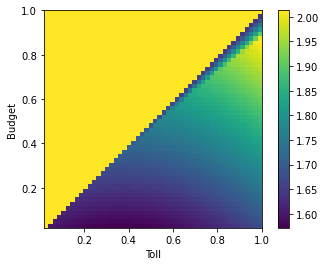

In [37]:
# lambda_E, lambda_R, lambda_I = 1.0, 1.0, 1.0

# plt.imshow(welfare_obj_arr.T, vmin = min(welfare_obj_list), vmax = max(welfare_obj_list), origin='lower') 
plt.imshow(welfare_obj_arr.T, extent=[np.min(tau_arr), np.max(tau_arr), np.min(B_arr), np.max(B_arr)], \
           vmin = min(welfare_obj_list), vmax = max(welfare_obj_list), origin='lower') 

plt.colorbar() 
plt.xlabel("Toll")
plt.ylabel("Budget")
# plt.xticks(x_positions, x_labels)

In [ ]:
# Test:

grad = np.array([3.11430535, 1.501, 1.501, 2.46858321, 1.501])

# y_el: \hat y_1 E, \tilde y_1 E, y_2 E
y_el_var = cp.Variable(3)
# y_in: y_1 I, y_2 I
y_in_var = cp.Variable(2)

objective = cp.Minimize(grad[0:3] @ y_el_var + grad[3:] @ y_in_var)

constraints = []
constraints += [y_el_var >= 0, y_in_var >= 0]
constraints += [cp.sum(y_el_var) == 1, cp.sum(y_in_var) == 1]
constraints += [y_el_var[1] * tau <= B]

prob = cp.Problem(objective, constraints)
result = prob.solve()

print("grad:", grad)
print("y_el_var.value:", y_el_var.value)
# print("y_el_var_current:", y_el_var_current)
print("y_in_var.value:", y_in_var.value)
# print("y_in_var_current:", y_in_var_current)
print()

# y_el_var_current = y_el_var_current + 2/(k+2) * (y_el_var.value - y_el_var_current)
# y_in_var_current = y_in_var_current + 2/(k+2) * (y_in_var.value - y_in_var_current)

# y_iters[0:3, k] = y_el_var_current
# y_iters[3:, k] = y_in_var_current

# The optimal objective value is returned by `prob.solve()`.
result = prob.solve()

# Solver=SCS,verbose=False

In [ ]:
# y_el_var
# y_in_var
# np.hstack((y_el_var, y_in_var))

# Scratch Work:

In [ ]:
x = cp.Variable(2)
y = cp.Variable(2)
v_fixed = np.array([0, 1])
objective = cp.Minimize(cp.sum_squares(x - y) + cp.sum_squares(x - v_fixed))
constraints = []
# for i in range(2):
#     constraints += [x[i] >= 2]
# constraints += [x[i] >=2 for i in range(2)]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
result = prob.solve()
# The optimal value for x is stored in `x.value`.
print("x.value:", x.value)
print("y.value:", y.value)
print()


# Old Code Below:

# Budget vs Discount - Theory

## 1 Eligible group, 1 Ineligible group (Theory)

In [ ]:
def F_11(val, ell, tau, alpha):
    return ell(val) + (1 - alpha) * tau - ell(2 - val)

def y_star_11(ell, tau, alpha, lb_init = 0.0, ub_init = 2.0, num_iters = 20):
    # Searches for y^\star satisfying ell(y^\star) + (1 - \alpha) \tau = ell(2 - y^\star)
    
    assert tau < ell(ub_init) - ell(lb_init), "We must have tau < ell(2.0) - ell(0.0), else is trivial."
    assert 0.0 <= alpha <= 1.0, "We must have 0.0 <= alpha <= 1.0"
    assert ell(lb_init) + (1.0 - alpha) * tau < ell(ub_init)
    
    lb = lb_init
    ub = ub_init
    mid_val = (lb + ub)/2
    
    for k in range(num_iters):
#         print("F:", F_11(mid_val, ell, tau, alpha))
#         print("lb:", lb)
#         print("ub:", ub)
#         print("mid_val:", mid_val)
#         print()
        
        if F_11(mid_val, ell, tau, alpha) < 0:
            lb = mid_val
        else:
            ub = mid_val
        mid_val = (lb + ub)/2
    
    return (lb + ub)/2

# def fixed_point_eqn():
    


In [ ]:
t_1 = time.time()

ell = lambda x: x**4 / 16
# ell = lambda x: np.log(1 + np.exp(x))
# alpha = 0.0

# # Case 1: 
# tau = 0.4
# v_E = 1
# v_I = 1.25

# # Case 2: 
# tau = 0.7
# v_E = 1
# v_I = 1.25

# Case 3: 
tau = 0.7
v_E = 1
v_I = 2.5

num_alpha_grid_points = 100 # Should be even
alpha_vals = np.linspace(0, 1.0, num = num_alpha_grid_points + 1)

y_star_zero = y_star_11(ell, tau, alpha = 0.0, lb_init = 0.0, ub_init = 2.0)
# print("y_star_zero:", y_star_zero)

y_star_vals = np.array([y_star_11(ell, tau, alpha, lb_init = 0.0, ub_init = 2.0) for alpha in alpha_vals])
y_star_vals_budget = alpha_vals
index_max = max([k for k in list(range(num_alpha_grid_points)) if alpha_vals[k] <= 1 - v_E/v_I])
# print("index_min:", index_min)
# print("alpha_vals[index_min]:", alpha_vals[index_min])
# print("y_star_vals_budget:", y_star_vals_budget)
# print()

# print("y_star_vals:", y_star_vals)
# print()

y_star_vals_discount = np.copy(y_star_vals)
for k in range(y_star_vals_discount.shape[0]):
    if k <= index_max:
        y_star_vals_discount[k] = 0.0

tau_thresh_for_alpha_3 = 2 * v_E * (ell(1) - ell(1 - 1E-6)) / 1E-6
index_for_alpha_3 = max([k for k in list(range(num_alpha_grid_points)) if y_star_vals[k] >= alpha_vals[k] ])
alpha_3 = (y_star_vals[index_for_alpha_3] + y_star_vals[index_for_alpha_3 + 1])/2

# print("y_star_vals_budget:", y_star_vals_budget)

# print("y_star_vals_budget:", y_star_vals_budget)


t_2 = time.time()
print("Time:", t_2 - t_1)

In [ ]:
print("1 - v^E / v^I:", 1 - v_E/v_I)
print("alpha_3:", alpha_3)

In [ ]:
plt.rcParams['text.usetex'] = True
# plt.rcParams['text.usetex'] = False

plt.plot(alpha_vals, y_star_vals_discount, 'red')
plt.plot(alpha_vals, y_star_vals_budget, 'blue')
# plt.scatter(alpha_vals, y_star_vals_discount, marker = 'o', s = 0.5, color = 'purple')
# plt.scatter(alpha_vals, y_star_vals_budget, marker = 'o', s = 0.5, color = 'black')
plt.xlim([0, 1.0])
plt.ylim([-0.2, 1.2])

plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlabel(r'$\displaystyle \alpha$', fontsize=24)
plt.ylabel(r'$\displaystyle y^C, y^D$', fontsize=24)
# plt.ylabel(r'$\displaystyle \ln(L^t - L^\star)$', fontsize=16)

# Scratch Work:

In [ ]:
# Test:

# y_el: \hat y_1 E, \tilde y_1 E, y_2 E
y_elig = cp.Variable(3)
# y_in: y_1 I, y_2 I
y_inel = cp.Variable(2)

a = np.array([0.0, 0.0, 0.0, 0.0, 1.0])

tau = 0.5
B = 0.4

func = 1/5 * a[4] * cp.power(y_elig[0] + y_elig[1] + y_inel[0], 5)
func += 1/4 * a[3] * cp.power(y_elig[0] + y_elig[1] + y_inel[0], 4)
func += 1/3 * a[2] * cp.power(y_elig[0] + y_elig[1] + y_inel[0], 3)
func += 1/2 * a[1] * cp.power(y_elig[0] + y_elig[1] + y_inel[0], 2)
func += a[0] * (y_elig[0] + y_elig[1] + y_inel[0])
func += y_inel[0] * tau / v_I + y_elig[0] * tau / v_E
func += 1/5 * a[4] * cp.power(y_elig[2] + y_inel[1], 5)
func += 1/4 * a[3] * cp.power(y_elig[2] + y_inel[1], 4)
func += 1/3 * a[2] * cp.power(y_elig[2] + y_inel[1], 3)
func += 1/2 * a[1] * cp.power(y_elig[2] + y_inel[1], 2)
func += a[0] * (y_elig[2] + y_inel[1])

objective = cp.Minimize(func)


constraints = []
constraints += [y_elig >= 0, y_inel >= 0]
constraints += [cp.sum(y_elig) == 1, cp.sum(y_inel) == 1]
constraints += [y_elig[1] * tau <= B]

prob = cp.Problem(objective, constraints)
result = prob.solve()

print("y_elig.value:", np.round(y_elig.value, 4) )
print("y_inel.value:", np.round(y_inel.value, 4) )
print()



# power(x, p)



# Frank-Wolfe Algorithm:

In [ ]:
# Below: For affine latency functions only:
def solve_CBCP_iter_11(tau, B, v_I, v_E, a = np.array([0.5, 1.0]), \
                       num_iters_max = 5000, error_bound = 1E-3, diffs_num_cols = 10, \
                       y_init = np.array([0.0, 0.0, 1.0, 1.0, 0.0]) ):
    
    # y = (\hat y_1 E, \tilde y_1 E, y_2 E, y_1 I, y_2 I)
    # a = (a_0, a_1)
    
#     print()    
#     print("Starting solve_CBCP_iter_11:")
#     print()
    
    # Initialize y_iters:
    y_iters = np.zeros((5, num_iters_max))
    
    y_el_var_current = y_init[0:3]
    y_in_var_current = y_init[3:]
    
    for k in range(num_iters_max):
        
        if k % 100 == 0:
            print("Inner iter:", k)
        
        # y_el: \hat y_1 E, \tilde y_1 E, y_2 E
        y_el_var = cp.Variable(3)
        # y_in: y_1 I, y_2 I
        y_in_var = cp.Variable(2)
        
        # Compute gradient:
        
        grad = np.zeros(5)
        grad[0] = a[1] * (y_el_var_current[0] + y_el_var_current[1] + y_in_var_current[0]) + a[0] + tau / v_E
        grad[1] = a[1] * (y_el_var_current[0] + y_el_var_current[1] + y_in_var_current[0]) + a[0]
        grad[2] = a[1] * (y_el_var_current[2] + y_in_var_current[1]) + a[0]
        grad[3] = a[1] * (y_el_var_current[0] + y_el_var_current[1] + y_in_var_current[0]) + a[0] + tau / v_I
        grad[4] = a[1] * (y_el_var_current[2] + y_in_var_current[1]) + a[0]
        
        ## Apply Frank-Wolfe:
        # Compute next iterate:
        
#         objective = cp.Minimize(0.5 * a[1] * (y_el_var[0] + y_el_var[1] + y_in_var[0])**2 \
#                                 + a[0] * (y_el_var[0] + y_el_var[1] + y_in_var[0]) \
#                                 + y_in_var[0] * tau / v_I + y_el_var[0] * tau / v_E \
#                                 + 0.5 * a[1] * (y_el_var[2] + y_in_var[1])**2 \
#                                 + a[0] * (y_el_var[2] + y_in_var[1]) )
        
        objective = cp.Minimize(grad[0:3] @ y_el_var + grad[3:] @ y_in_var)

        constraints = []
        constraints += [y_el_var >= 0, y_in_var >= 0]
        constraints += [cp.sum(y_el_var) == 1, cp.sum(y_in_var) == 1]
        constraints += [y_el_var[1] * tau <= B]
    
        prob = cp.Problem(objective, constraints)
        result = prob.solve()
        
#         print("grad:", grad)
#         print("y_el_var.value:", y_el_var.value)
#         print("y_in_var.value:", y_in_var.value)
#         print("y_el_var_current:", y_el_var_current)
#         print("y_in_var_current:", y_in_var_current)
        
        y_el_var_current = y_el_var_current + 2/(k+2) * (y_el_var.value - y_el_var_current)
        y_in_var_current = y_in_var_current + 2/(k+2) * (y_in_var.value - y_in_var_current)
        
#         print("y_el_var_current (new):", y_el_var_current)
#         print("y_in_var_current (new):", y_in_var_current)
#         print()
        
        y_iters[0:3, k] = y_el_var_current
        y_iters[3:, k] = y_in_var_current
        
        if k >= diffs_num_cols + 2:
            diffs = np.linalg.norm(y_iters[:, k-diffs_num_cols-1:k-2] - y_iters[:, k-diffs_num_cols:k-1], axis = 0)

            if np.max(diffs) < error_bound:
                break
    
    return y_el_var_current, y_in_var_current
